<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Repo already exists at: /content/ZZSC9020-Group_F
Pulling changes from repo...
Already up to date.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [219]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

,datetime_au,is_summer,is_autumn,is_winter,is_spring,is_sunday,is_monday,is_tuesday,is_wednesday,is_thursday,...,max_30_min_demand,sum_30_min_demand,count_30_min_points,avg_temp,min_temp,max_temp,hd_next_24h,cd_next_24h,precipitation,sunlight
0,2016-01-01,1,0,0,0,0,0,0,0,0,...,7913.75,329352.88,48,20.704082,15.2,26.0,0.0,1.204082,2.140095,32.3
1,2016-01-02,1,0,0,0,0,0,0,0,0,...,7390.04,323133.95,48,20.572917,14.9,24.2,0.0,1.072917,6.496326,23.2
2,2016-01-03,1,0,0,0,1,0,0,0,0,...,7328.39,317665.92,48,21.130769,19.0,22.9,0.0,1.630769,8.562486,12.7
3,2016-01-04,1,0,0,0,0,1,0,0,0,...,8313.11,353210.40,48,20.144444,18.4,23.1,0.0,0.644444,4.082204,7.6
4,2016-01-05,1,0,0,0,0,0,1,0,0,...,8338.82,358082.97,48,18.904808,17.4,20.3,0.0,0.000000,9.977372,3.9


In [220]:
test_df

,datetime_au,is_summer,is_autumn,is_winter,is_spring,is_sunday,is_monday,is_tuesday,is_wednesday,is_thursday,...,max_30_min_demand,sum_30_min_demand,count_30_min_points,avg_temp,min_temp,max_temp,hd_next_24h,cd_next_24h,precipitation,sunlight
0,2016-01-01,1,0,0,0,0,0,0,0,0,...,7913.75,329352.88,48,20.704082,15.2,26.0,0.0,1.204082,2.140095,32.3
1,2016-01-02,1,0,0,0,0,0,0,0,0,...,7390.04,323133.95,48,20.572917,14.9,24.2,0.0,1.072917,6.496326,23.2
2,2016-01-03,1,0,0,0,1,0,0,0,0,...,7328.39,317665.92,48,21.130769,19.0,22.9,0.0,1.630769,8.562486,12.7
3,2016-01-04,1,0,0,0,0,1,0,0,0,...,8313.11,353210.40,48,20.144444,18.4,23.1,0.0,0.644444,4.082204,7.6
4,2016-01-05,1,0,0,0,0,0,1,0,0,...,8338.82,358082.97,48,18.904808,17.4,20.3,0.0,0.000000,9.977372,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2019-12-27,1,0,0,0,0,0,0,0,0,...,9324.59,360393.59,48,23.654717,19.2,28.5,0.0,4.154717,0.081469,30.7
1457,2019-12-28,1,0,0,0,0,0,0,0,0,...,9806.43,369325.03,48,24.309615,16.6,29.9,0.0,4.809615,0.571150,30.8
1458,2019-12-29,1,0,0,0,1,0,0,0,0,...,9773.20,371819.56,48,23.689583,18.1,29.3,0.0,4.189583,0.101862,21.8
1459,2019-12-30,1,0,0,0,0,1,0,0,0,...,10848.99,399427.25,48,24.172917,18.1,31.0,0.0,4.672917,0.243804,26.3


In [221]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

,is_summer,is_autumn,is_winter,is_spring,is_sunday,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday,...,max_30_min_demand,sum_30_min_demand,count_30_min_points,avg_temp,min_temp,max_temp,hd_next_24h,cd_next_24h,precipitation,sunlight
datetime_au,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,0,0,0,0,0,0,0,0,1,...,7913.75,329352.88,48,20.704082,15.2,26.0,0.000000,1.204082,2.140095,32.3
2016-01-02,1,0,0,0,0,0,0,0,0,0,...,7390.04,323133.95,48,20.572917,14.9,24.2,0.000000,1.072917,6.496326,23.2
2016-01-03,1,0,0,0,1,0,0,0,0,0,...,7328.39,317665.92,48,21.130769,19.0,22.9,0.000000,1.630769,8.562486,12.7
2016-01-04,1,0,0,0,0,1,0,0,0,0,...,8313.11,353210.40,48,20.144444,18.4,23.1,0.000000,0.644444,4.082204,7.6
2016-01-05,1,0,0,0,0,0,1,0,0,0,...,8338.82,358082.97,48,18.904808,17.4,20.3,0.000000,0.000000,9.977372,3.9
2016-01-06,1,0,0,0,0,0,0,1,0,0,...,8256.95,357451.06,48,17.448148,16.6,18.1,0.000000,0.000000,2.932764,2.6
2016-01-07,1,0,0,0,0,0,0,0,1,0,...,7954.59,351570.67,48,19.067045,15.7,22.5,0.000000,0.000000,0.130372,25.1
2016-01-08,1,0,0,0,0,0,0,0,0,1,...,8340.45,355814.96,48,19.897674,13.9,25.2,0.000000,0.397674,0.018615,28.3
2016-01-09,1,0,0,0,0,0,0,0,0,0,...,8055.57,344216.79,48,21.297917,16.7,25.5,0.000000,1.797917,0.354907,24.3


In [222]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## 1. Base Model - Avg Demand Only ##

In [223]:
demandDF = test_df[['avg_30_min_demand']]
demandDF

,avg_30_min_demand
datetime_au,
2016-01-01,6861.518333
2016-01-02,6731.957292
2016-01-03,6618.040000
2016-01-04,7358.550000
2016-01-05,7460.061875
...,...
2019-12-27,7508.199792
2019-12-28,7694.271458
2019-12-29,7746.240833


In [224]:
scaler = MinMaxScaler()
demandDF_scaled = pd.DataFrame(scaler.fit_transform(demandDF), index=demandDF.index, columns=demandDF.columns)

### Helper Functions ###

In [225]:
def to_X_and_y(df, window_size=7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def split_time_series(df, window_size=7, allow_overlap=False):
    years = sorted(df.index.year.unique())

    def get_year_slice(year):
        return df[df.index.year == year].copy()

    def get_extended_slice(current_year, prior_year):
        prior_tail = df[(df.index.year == prior_year) & (df.index >= f"{prior_year}-12-{31 - window_size + 1}")]
        current_full = get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    if allow_overlap:
        df_train = pd.concat([get_year_slice(years[0]), get_year_slice(years[1])])
        df_val = get_extended_slice(years[2], years[1])
        df_test = get_extended_slice(years[3], years[2])

    else:
        df_train = pd.concat([get_year_slice(years[0]), get_year_slice(years[1])])
        df_val = get_year_slice(years[2])
        df_test = get_year_slice(years[3])

    X_train, y_train = to_X_and_y(df_train, window_size)
    X_val, y_val = to_X_and_y(df_val, window_size)
    X_test, y_test = to_X_and_y(df_test, window_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)




### Setup function for printing, metrics ###

In [226]:
def mape(a, p, eps=1e-8):
    return (np.abs((a - p) / np.clip(np.abs(a), eps, None))).mean() * 100

In [306]:
def predictions_plot(model, X, y, start = 0, end = 100):
    y_pred = model.predict(X)

    y_orig = target_scaler.inverse_transform(y.reshape(-1,1)).ravel()
    y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()

    predictions = model.predict(X).flatten()
    results = pd.DataFrame(data={'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

### Train, val, test splits

In [228]:
X, y = to_X_and_y(demandDF_scaled)
X.shape, y.shape

((1454, 7, 1), (1454,))

In [229]:
yearly_counts = demandDF_scaled.index.year.value_counts().sort_index()
print(yearly_counts)

datetime_au
2016    366
2017    365
2018    365
2019    365
Name: count, dtype: int64


In [230]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_time_series(demandDF_scaled, window_size=7, allow_overlap=False)

In [231]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((724, 7, 1), (724,), (358, 7, 1), (358,), (358, 7, 1), (358,))

In [232]:
(X_train2, y_train2), (X_val2, y_val2), (X_test2, y_test2) = split_time_series(demandDF_scaled, window_size=7, allow_overlap=True)

In [233]:
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((724, 7, 1), (724,), (365, 7, 1), (365,), (365, 7, 1), (365,))

### Model 1 ###

In [234]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [235]:
cp = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

In [236]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0904 - mean_absolute_percentage_error: 353728.1562 - root_mean_squared_error: 0.2956 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 40.1152 - val_root_mean_squared_error: 0.1184
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - mean_absolute_percentage_error: 124012.3594 - root_mean_squared_error: 0.1251 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 39.4364 - val_root_mean_squared_error: 0.1172
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182 - mean_absolute_percentage_error: 2586845.2500 - root_mean_squared_error: 0.1349 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 36.2270 - val_root_mean_squared_error: 0.1123
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0166 - mean_absolute_percentage_error: 151384.3125 - root_mean_squared_error: 0.1289 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 33.8486 - val_root_mean_squared_error: 0.1118

In [237]:
model1 = load_model('model1.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


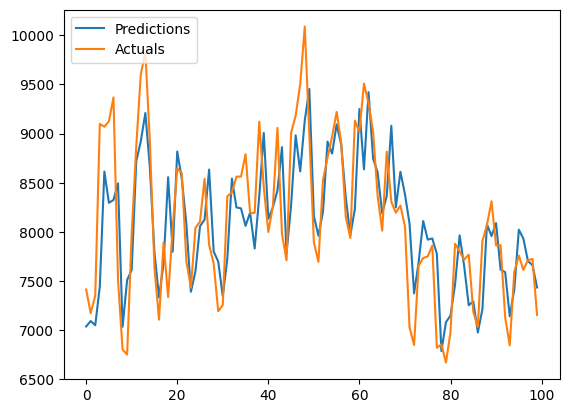

MAPE: 3.94%
RMSE: 430.38
MAE : 319.82


,Predictions,Actuals
0,7035.967285,7412.811667
1,7091.479004,7171.183125
2,7048.478027,7350.264167
3,7441.920410,9098.258333
4,8613.583984,9070.002917
...,...,...
719,7902.249023,7374.332292
720,7859.975586,8039.583333
721,8183.614746,8575.767292
722,8357.468750,7909.507917


In [238]:
predictions_plot(model1, X_train, y_train, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


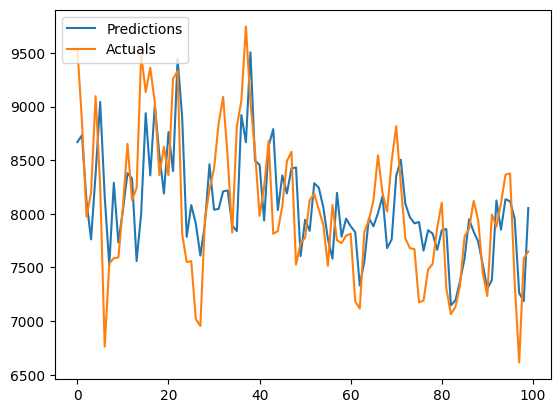

MAPE: 3.77%
RMSE: 392.40
MAE : 300.94


,Predictions,Actuals
0,8669.132812,9537.097917
1,8731.533203,8863.333125
2,8116.734375,7973.787500
3,7761.750000,8194.981667
4,8374.092773,9096.434375
...,...,...
353,7961.908691,8447.030417
354,7969.364746,8771.408958
355,7787.107422,8487.014792
356,7607.841797,8380.489792


In [239]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


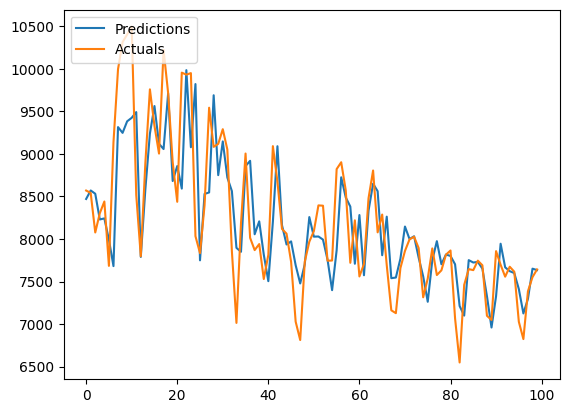

MAPE: 3.90%
RMSE: 416.29
MAE : 311.63


,Predictions,Actuals
0,8470.509766,8569.568125
1,8570.399414,8540.904167
2,8531.850586,8076.513125
3,8229.772461,8302.971875
4,8242.095703,8440.820000
...,...,...
353,7631.683594,7508.199792
354,7730.691406,7694.271458
355,7441.285156,7746.240833
356,7560.784180,8321.401042


In [240]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 ###

In [241]:
model2 = Sequential()
model2.add(InputLayer((7, 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [242]:
cp = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [243]:
model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1101 - root_mean_squared_error: 0.3292 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1442
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - root_mean_squared_error: 0.1513 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1185
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - l

In [244]:
model2 = load_model('model2.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


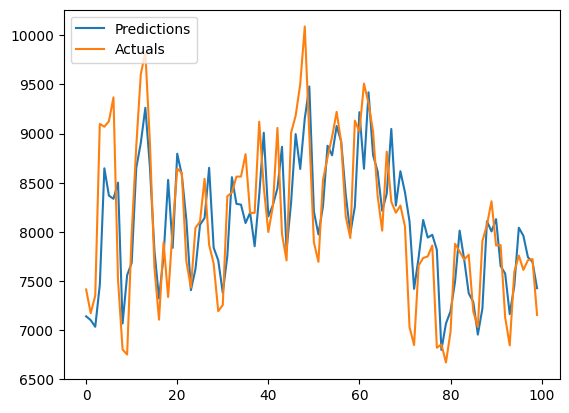

MAPE: 3.94%
RMSE: 427.89
MAE : 318.43


,Predictions,Actuals
0,7139.220703,7412.811667
1,7100.672852,7171.183125
2,7033.049316,7350.264167
3,7460.122559,9098.258333
4,8646.347656,9070.002917
...,...,...
719,7949.783203,7374.332292
720,7873.646973,8039.583333
721,8215.157227,8575.767292
722,8428.669922,7909.507917


In [245]:
predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


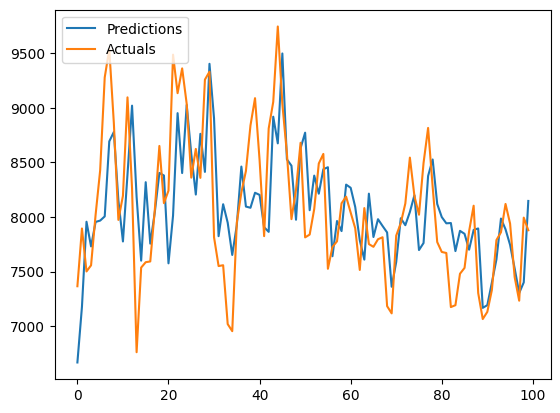

MAPE: 3.82%
RMSE: 397.06
MAE : 304.31


,Predictions,Actuals
0,6667.560547,7365.989375
1,7177.067383,7895.121667
2,7956.919922,7501.373542
3,7730.600098,7557.751458
4,7955.389160,8021.308125
...,...,...
360,7997.402344,8447.030417
361,8116.867676,8771.408958
362,8036.654297,8487.014792
363,7701.569336,8380.489792


In [246]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


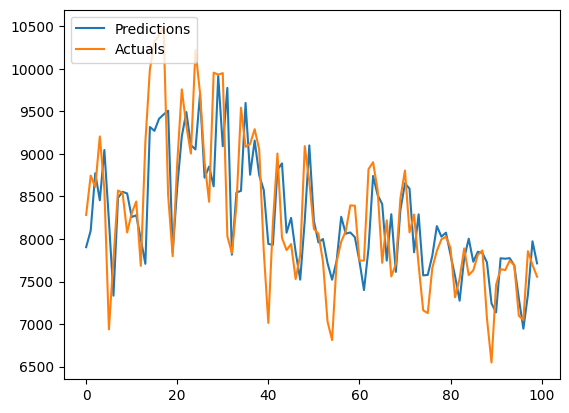

MAPE: 3.95%
RMSE: 419.95
MAE : 314.33


,Predictions,Actuals
0,7904.176758,8282.850208
1,8098.554688,8745.688125
2,8772.869141,8612.550625
3,8454.931641,9205.374583
4,9046.027344,8584.935417
...,...,...
360,7668.655762,7508.199792
361,7781.913086,7694.271458
362,7454.769531,7746.240833
363,7589.793457,8321.401042


In [247]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [265]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]
input_scaler = MinMaxScaler()
tempDemandDF_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF), index=tempDemandDF.index, columns=tempDemandDF.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF[['avg_30_min_demand']])

tempDemandDF_scaled.head()

,avg_30_min_demand,avg_temp
datetime_au,,
2016-01-01,0.124113,0.552121
2016-01-02,0.095582,0.547043
2016-01-03,0.070495,0.568640
2016-01-04,0.233569,0.530455
2016-01-05,0.255923,0.482463


In [266]:
def multi_to_X_and_y(df, window_size=7, target_index=0):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size, :]
        X.append(row)
        label = df_as_np[i+window_size, target_index]
        y.append(label)
    return np.array(X), np.array(y)

In [267]:
X, y = multi_to_X_and_y(tempDemandDF_scaled)
X.shape, y.shape

((1454, 7, 2), (1454,))

In [268]:
(X_train3, y_train3), (X_val3, y_val3), (X_test3, y_test3) = split_time_series(tempDemandDF_scaled, window_size=7, allow_overlap=False)

In [269]:
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((724, 7, 2), (724,), (358, 7, 2), (358,), (358, 7, 2), (358,))

### Model 3 ###

In [283]:
model3 = Sequential()
model3.add(InputLayer((7, 2)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [284]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [285]:
model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1280 - root_mean_squared_error: 0.3481 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0176 - root_mean_squared_error: 0.1324 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

In [286]:
model3 = load_model('model3.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


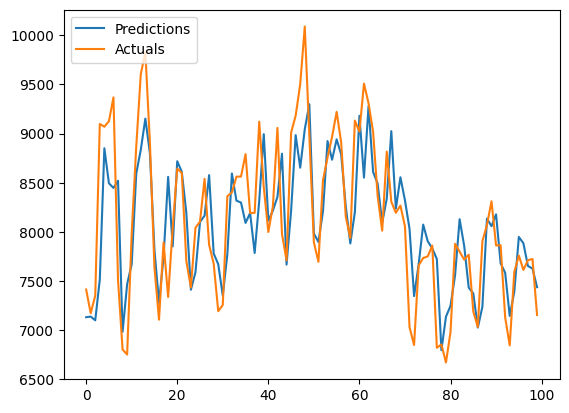

MAPE: 3.91%
RMSE: 426.28
MAE : 317.25


,Predictions,Actuals
0,7130.359375,7412.811667
1,7136.560059,7171.183125
2,7098.699707,7350.264167
3,7514.818359,9098.258333
4,8850.911133,9070.002917
...,...,...
719,7906.255371,7374.332292
720,8012.893555,8039.583333
721,8378.771484,8575.767292
722,8556.636719,7909.507917


In [287]:
predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


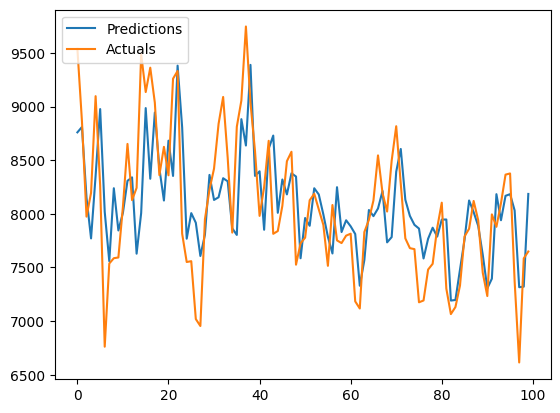

MAPE: 3.72%
RMSE: 383.03
MAE : 296.38


,Predictions,Actuals
0,8759.184570,9537.097917
1,8809.042969,8863.333125
2,8151.899902,7973.787500
3,7770.715820,8194.981667
4,8355.009766,9096.434375
...,...,...
353,8003.599121,8447.030417
354,8388.314453,8771.408958
355,8285.804688,8487.014792
356,7904.999512,8380.489792


In [288]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


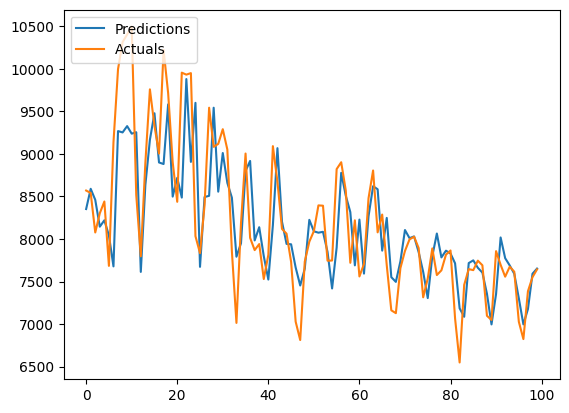

MAPE: 3.98%
RMSE: 423.74
MAE : 317.52


,Predictions,Actuals
0,8352.281250,8569.568125
1,8589.911133,8540.904167
2,8459.920898,8076.513125
3,8144.828125,8302.971875
4,8219.849609,8440.820000
...,...,...
353,7700.216797,7508.199792
354,7984.118652,7694.271458
355,7895.232910,7746.240833
356,7928.746094,8321.401042


In [289]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

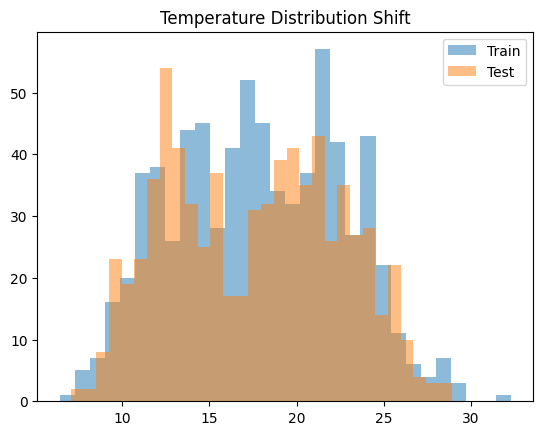

In [290]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [292]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]
input_scaler = MinMaxScaler()
tempDemandDF2_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF2), index=tempDemandDF2.index, columns=tempDemandDF2.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF2[['avg_30_min_demand']])

tempDemandDF2_scaled.head()

,avg_30_min_demand,avg_temp,min_temp,max_temp
datetime_au,,,,
2016-01-01,0.124113,0.552121,0.615672,0.444099
2016-01-02,0.095582,0.547043,0.604478,0.388199
2016-01-03,0.070495,0.568640,0.757463,0.347826
2016-01-04,0.233569,0.530455,0.735075,0.354037
2016-01-05,0.255923,0.482463,0.697761,0.267081


In [293]:
X, y = multi_to_X_and_y(tempDemandDF2_scaled)
X.shape, y.shape

((1454, 7, 4), (1454,))

In [294]:
(X_train4, y_train4), (X_val4, y_val4), (X_test4, y_test4) = split_time_series(tempDemandDF2_scaled, window_size=7, allow_overlap=False)

In [295]:
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((724, 7, 4), (724,), (358, 7, 4), (358,), (358, 7, 4), (358,))

## Model 4 ##

In [297]:
model4 = Sequential()
model4.add(InputLayer((7, 4)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [298]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [299]:
model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0649 - root_mean_squared_error: 0.2538 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1557
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [300]:
model4 = load_model('model4.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


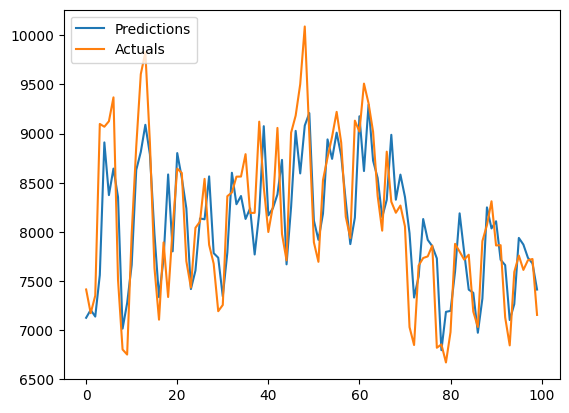

MAPE: 3.85%
RMSE: 416.74
MAE : 311.57


,Predictions,Actuals
0,7124.626465,7412.811667
1,7205.197754,7171.183125
2,7136.870605,7350.264167
3,7560.064453,9098.258333
4,8910.259766,9070.002917
...,...,...
719,7766.163574,7374.332292
720,8068.201660,8039.583333
721,8342.255859,8575.767292
722,8459.501953,7909.507917


In [309]:
predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


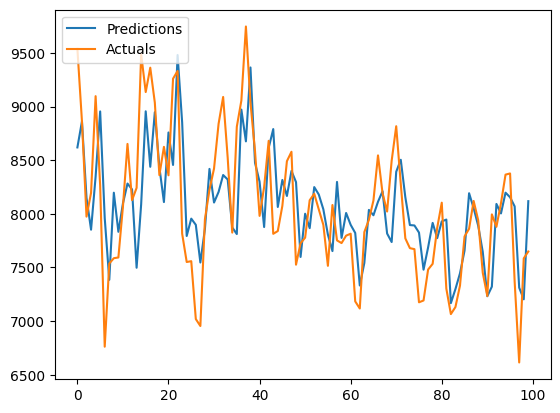

MAPE: 3.67%
RMSE: 377.36
MAE : 292.12


,Predictions,Actuals
0,8618.731445,9537.097917
1,8861.023438,8863.333125
2,8149.953125,7973.787500
3,7852.143066,8194.981667
4,8346.431641,9096.434375
...,...,...
353,8011.899902,8447.030417
354,8389.663086,8771.408958
355,8324.183594,8487.014792
356,7973.408203,8380.489792


In [308]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


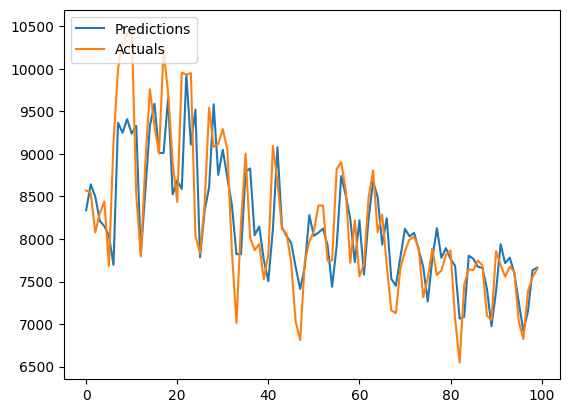

MAPE: 3.91%
RMSE: 411.78
MAE : 310.70


,Predictions,Actuals
0,8337.478516,8569.568125
1,8642.980469,8540.904167
2,8498.291992,8076.513125
3,8212.792969,8302.971875
4,8150.799316,8440.820000
...,...,...
353,7765.011719,7508.199792
354,7921.083496,7694.271458
355,7865.117188,7746.240833
356,7864.275391,8321.401042


In [307]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

In [305]:
zero_count = np.min(test_df["avg_30_min_demand"])
print(f"Number of zeros in y_true: {zero_count}")

Number of zeros in y_true: 6297.925208333333


## Model 5 ##

In [312]:
tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']].copy()
tempDemandDF3['temp_range'] = tempDemandDF3['max_temp'] - tempDemandDF3['min_temp']
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)
tempDemandDF3.head()

,avg_30_min_demand,avg_temp,temp_range
datetime_au,,,
2016-01-01,6861.518333,20.704082,10.8
2016-01-02,6731.957292,20.572917,9.3
2016-01-03,6618.040000,21.130769,3.9
2016-01-04,7358.550000,20.144444,4.7
2016-01-05,7460.061875,18.904808,2.9


In [313]:
input_scaler = MinMaxScaler()
tempDemandDF3_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF3), index=tempDemandDF3.index, columns=tempDemandDF3.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF3[['avg_30_min_demand']])

tempDemandDF3_scaled.head()

,avg_30_min_demand,avg_temp,temp_range
datetime_au,,,
2016-01-01,0.124113,0.552121,0.406114
2016-01-02,0.095582,0.547043,0.340611
2016-01-03,0.070495,0.568640,0.104803
2016-01-04,0.233569,0.530455,0.139738
2016-01-05,0.255923,0.482463,0.061135


In [314]:
X, y = multi_to_X_and_y(tempDemandDF3_scaled)
X.shape, y.shape

((1454, 7, 3), (1454,))

In [315]:
(X_train5, y_train5), (X_val5, y_val5), (X_test5, y_test5) = split_time_series(tempDemandDF3_scaled, window_size=7, allow_overlap=False)

In [316]:
X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((724, 7, 3), (724,), (358, 7, 3), (358,), (358, 7, 3), (358,))

In [317]:
model5 = Sequential()
model5.add(InputLayer((7, 3)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [318]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [319]:
model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1411 - root_mean_squared_error: 0.3651 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1294
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - root_mean_squared_error: 0.1269 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

In [320]:
model5 = load_model('model5.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


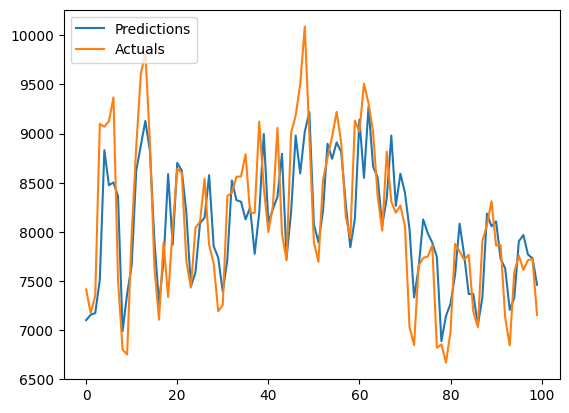

MAPE: 3.92%
RMSE: 422.58
MAE : 316.55


,Predictions,Actuals
0,7100.314941,7412.811667
1,7155.535156,7171.183125
2,7172.197754,7350.264167
3,7511.735352,9098.258333
4,8830.600586,9070.002917
...,...,...
719,7799.650391,7374.332292
720,8033.140137,8039.583333
721,8306.808594,8575.767292
722,8452.850586,7909.507917


In [321]:
predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


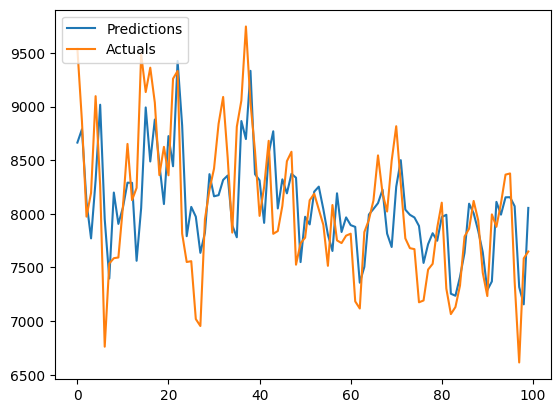

MAPE: 3.78%
RMSE: 384.12
MAE : 300.68


,Predictions,Actuals
0,8663.728516,9537.097917
1,8787.775391,8863.333125
2,8109.958984,7973.787500
3,7770.995117,8194.981667
4,8313.242188,9096.434375
...,...,...
353,7955.480469,8447.030417
354,8315.331055,8771.408958
355,8195.656250,8487.014792
356,7816.220215,8380.489792


In [322]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


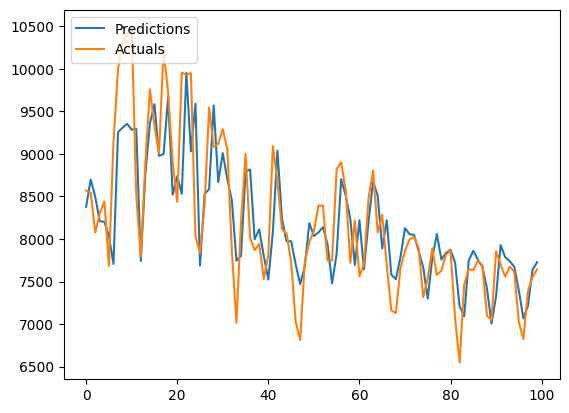

MAPE: 3.99%
RMSE: 418.70
MAE : 316.81


,Predictions,Actuals
0,8378.753906,8569.568125
1,8698.914062,8540.904167
2,8495.837891,8076.513125
3,8208.441406,8302.971875
4,8202.773438,8440.820000
...,...,...
353,7615.141602,7508.199792
354,7862.317871,7694.271458
355,7721.859375,7746.240833
356,7787.985352,8321.401042


In [323]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [324]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']].copy()
tempDemandDF4['temp_range'] = tempDemandDF4['max_temp'] - tempDemandDF4['min_temp']
tempDemandDF4.head()

,avg_30_min_demand,avg_temp,min_temp,max_temp,temp_range
datetime_au,,,,,
2016-01-01,6861.518333,20.704082,15.2,26.0,10.8
2016-01-02,6731.957292,20.572917,14.9,24.2,9.3
2016-01-03,6618.040000,21.130769,19.0,22.9,3.9
2016-01-04,7358.550000,20.144444,18.4,23.1,4.7
2016-01-05,7460.061875,18.904808,17.4,20.3,2.9


In [325]:
input_scaler = MinMaxScaler()
tempDemandDF4_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF4), index=tempDemandDF4.index, columns=tempDemandDF4.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF4[['avg_30_min_demand']])

tempDemandDF4_scaled.head()

,avg_30_min_demand,avg_temp,min_temp,max_temp,temp_range
datetime_au,,,,,
2016-01-01,0.124113,0.552121,0.615672,0.444099,0.406114
2016-01-02,0.095582,0.547043,0.604478,0.388199,0.340611
2016-01-03,0.070495,0.568640,0.757463,0.347826,0.104803
2016-01-04,0.233569,0.530455,0.735075,0.354037,0.139738
2016-01-05,0.255923,0.482463,0.697761,0.267081,0.061135


In [326]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled)
X.shape, y.shape

((1454, 7, 5), (1454,))

In [327]:
(X_train6, y_train6), (X_val6, y_val6), (X_test6, y_test6) = split_time_series(tempDemandDF4_scaled, window_size=7, allow_overlap=False)

In [328]:
X_train6.shape, y_train6.shape, X_val6.shape, y_val6.shape, X_test6.shape, y_test6.shape

((724, 7, 5), (724,), (358, 7, 5), (358,), (358, 7, 5), (358,))

In [329]:
model6 = Sequential()
model6.add(InputLayer((7, 5)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [330]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [331]:
model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0836 - root_mean_squared_error: 0.2846 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1222
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0192 - root_mean_squared_error: 0.1382 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [332]:
model6 = load_model('model6.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


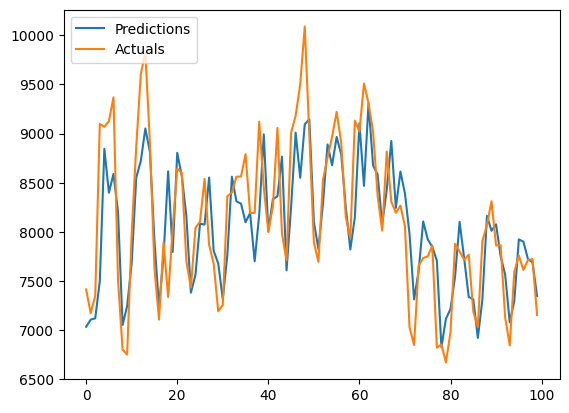

MAPE: 3.73%
RMSE: 408.68
MAE : 302.50


,Predictions,Actuals
0,7033.177246,7412.811667
1,7106.031738,7171.183125
2,7119.088867,7350.264167
3,7497.730469,9098.258333
4,8844.665039,9070.002917
...,...,...
719,7712.458496,7374.332292
720,8008.584961,8039.583333
721,8281.553711,8575.767292
722,8418.367188,7909.507917


In [333]:
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


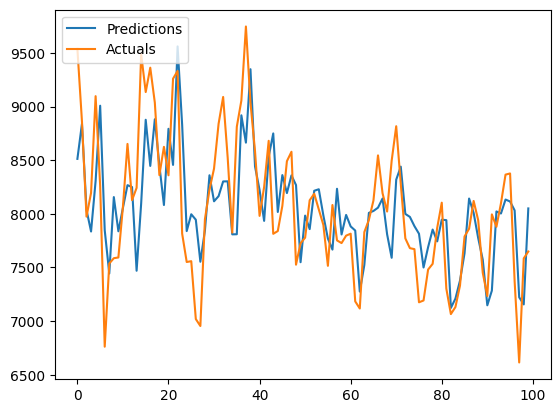

MAPE: 3.64%
RMSE: 376.10
MAE : 289.92


,Predictions,Actuals
0,8512.033203,9537.097917
1,8838.199219,8863.333125
2,8036.222656,7973.787500
3,7835.239746,8194.981667
4,8305.917969,9096.434375
...,...,...
353,7932.368164,8447.030417
354,8338.625000,8771.408958
355,8227.248047,8487.014792
356,7826.791016,8380.489792


In [334]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


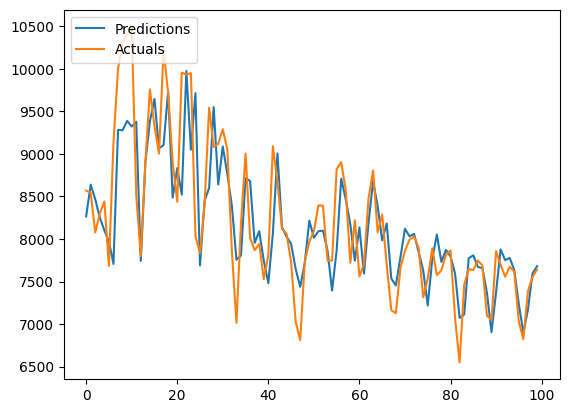

MAPE: 3.80%
RMSE: 405.98
MAE : 302.20


,Predictions,Actuals
0,8266.013672,8569.568125
1,8638.591797,8540.904167
2,8466.511719,8076.513125
3,8251.980469,8302.971875
4,8102.605469,8440.820000
...,...,...
353,7654.296875,7508.199792
354,7865.008301,7694.271458
355,7746.353516,7746.240833
356,7800.617188,8321.401042


In [335]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size ##

In [336]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled, window_size=10)
X.shape, y.shape

((1451, 10, 5), (1451,))

In [337]:
(X_train7, y_train7), (X_val7, y_val7), (X_test7, y_test7) = split_time_series(tempDemandDF4_scaled, window_size=10, allow_overlap=False)

In [338]:
X_train7.shape, y_train7.shape, X_val7.shape, y_val7.shape, X_test7.shape, y_test7.shape

((721, 10, 5), (721,), (355, 10, 5), (355,), (355, 10, 5), (355,))

In [339]:
model7 = Sequential()
model7.add(InputLayer((10, 5)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [340]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [341]:
model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0957 - root_mean_squared_error: 0.3031 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - root_mean_squared_error: 0.1457 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [342]:
model7 = load_model('model7.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


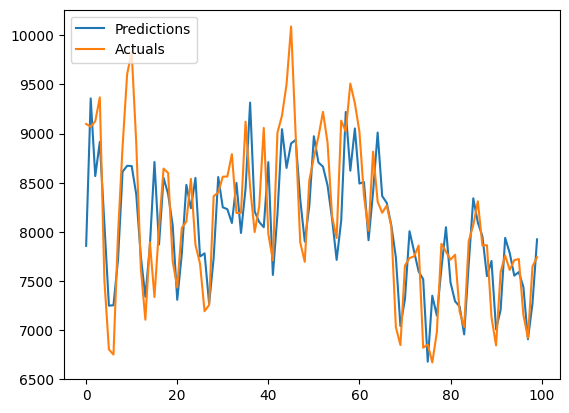

MAPE: 3.87%
RMSE: 415.80
MAE : 314.73


,Predictions,Actuals
0,7857.477051,9098.258333
1,9358.118164,9070.002917
2,8567.455078,9125.678750
3,8915.341797,9368.951875
4,8084.551270,7510.325833
...,...,...
716,7466.826660,7374.332292
717,7720.589355,8039.583333
718,7941.969238,8575.767292
719,8082.296875,7909.507917


In [343]:
predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


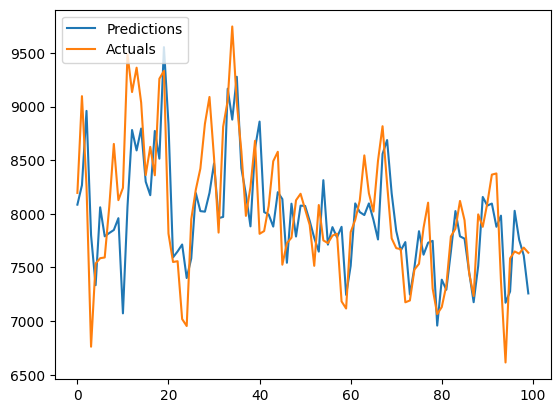

MAPE: 3.68%
RMSE: 379.92
MAE : 294.14


,Predictions,Actuals
0,8085.378906,8194.981667
1,8266.682617,9096.434375
2,8959.186523,8261.405417
3,7801.321777,6761.608125
4,7334.819824,7536.762292
...,...,...
350,7805.997070,8447.030417
351,8217.600586,8771.408958
352,8174.829590,8487.014792
353,7732.840332,8380.489792


In [344]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


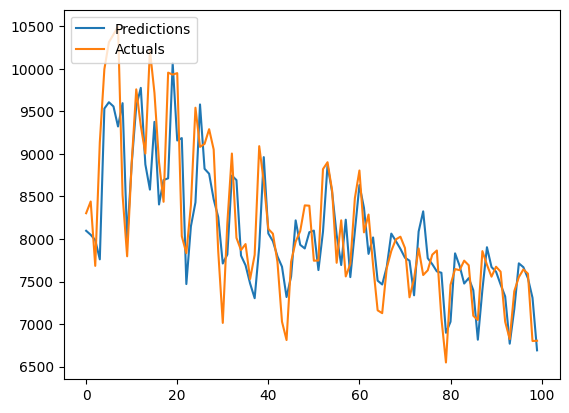

MAPE: 3.97%
RMSE: 413.42
MAE : 316.88


,Predictions,Actuals
0,8096.802734,8302.971875
1,8049.449219,8440.820000
2,7987.338867,7684.176042
3,7761.022461,9135.772083
4,9532.953125,9995.508542
...,...,...
350,7573.783203,7508.199792
351,7689.039062,7694.271458
352,7705.972168,7746.240833
353,7641.856445,8321.401042


In [345]:
predictions_plot(model7, X_test7, y_test7, 0, 100)